# Plastic Classifier

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/surfriderfoundationeurope/IA_Pau/blob/master/Hackaton_Surfrider_Getting_Started.ipynb)


The goal is to build a plastic classifier, as the core detector / tracker is already built (but only works for generic plastic).

If you want fast training, make sure you have a good GPU: check using the command `!nvidia-smi`

Please install the required packages:   
`pip install -r requirements.txt`

### Getting the data

To get the images of [taco](http://tacodataset.org/) project, you download the dataset from [here](https://www.kaggle.com/kneroma/tacotrashdataset).        
Then put the `data` content folder in the `data/images/` folder of this repository, to have this structure:
- `data/images/images-taco/`
    - `bach_1/`
    - `bach_2/`
    - `bach_3/`
    - ...
    - `annotations.json`
    - `meta_df.csv`

In [92]:
import json
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import cv2

# Constants

In [94]:
images_folder = '../../data/images/images-taco/'
annotationFile = images_folder + 'meta_df.csv'
annotationFileTrain = images_folder + 'meta_df_train.csv'
annotationFileTest = images_folder + 'meta_df_test.csv'

# Pre-processing

## 1 - Load images

In [95]:
dataset = pd.read_csv(annotationFile)

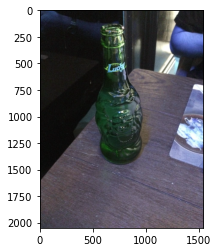

In [113]:
data = dataset.iloc[0]

# 1 - load data
img = cv2.imread(images_folder + data['img_file'])
plt.imshow(img)

In [122]:
# 2 - Detect trash

from torch.utils.data import DataLoader

# model = load_model(arch='res_18', model_weights='models/res18_pretrained.pth', device='cuda').eval()
# loader = DataLoader(img, shuffle=False, batch_size=16)
# imgPreprocessed = pre_process_centernet(img)


# results = detect(imgPreprocessed, threshold=0.3, model=model)

from eval import * 

def compute_model_outputs2(dataset, arch):

    device = torch.device('cuda')

    transforms = ValTransforms(540, (544,960), 1, 4)
    loader = DataLoader(dataset, shuffle=False, batch_size=16)

    if arch == 'res_18':
        weights_path = 'models/res18_pretrained.pth'
    elif arch == 'mobilenetv3small':
        weights_path = 'models/mobilenet_v3_pretrained.pth'
    elif arch == 'dla_34':
        weights_path = 'models/dla_34_pretrained.pth'

    model = load_model(arch, weights_path, device=device)
    model.eval()

    all_heatmaps = []
    all_gt = []

    for batch_images, batch_labels in tqdm(loader): 
        batch_labels = batch_labels[:,0,:,:]
        batch_output = model(batch_images.to(device))
        batch_heatmaps = torch.sigmoid(batch_output[-1]['hm']).squeeze(dim=1).cpu()
        batch_gt = (batch_labels == 1)
        all_gt.extend(batch_gt)
        all_heatmaps.extend(batch_heatmaps)
 
    with open(f'eval_heatmaps_{arch}.pickle','wb') as f:
        pickle.dump(torch.stack(all_heatmaps), f)
    with open(f'eval_gt_{arch}.pickle','wb') as f:
        pickle.dump(torch.stack(all_gt), f)

arch = 'res_18'
compute_model_outputs2(dataset, arch)
load_model_outputs(arch)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth


  0%|          | 0/299 [00:00<?, ?it/s]


KeyError: 0

In [ ]:
size = (224, 224)
model = torch.load('../../models/centernet/res18_pretrained.pth')

for index, data in dataset.iterrows():
    # 1 - Load image
    img = plt.imread(images_folder + data['img_file'])
    # 2 - Detect trash
    result = detect(img, size, model)
    # 3 - Save trash image (resize all images to the same size)



## Split train / test datasets

In [ ]:
# A REFAIRE
train_ratio=0.8
with open(annotationFile, 'r') as f:
    lines = f.readlines()
    header = lines[0]
    lines = lines[1:]
    random.shuffle(lines)
    train_size = int(len(lines) * train_ratio)
    train_lines = lines[:train_size]
    test_lines = lines[train_size:]
    with open(annotationFileTrain, 'w') as f_train:
        f_train.write(header)
        f_train.writelines(train_lines)
    with open(annotationFileTest, 'w') as f_test:
        f_test.write(header)
        f_test.writelines(test_lines)

# Analyse the dataset

the next following cells enable you to get a bit of information about the dataset

In [ ]:
coco_categories = dataset['supercategory']

# get coco categories names and how many images are in each category
cat_names = list(set(coco_categories))
nb_images = {}
for cat in cat_names:
    nb_images.update({cat: len(coco_categories[coco_categories == cat])})
# sort by number of images
cat_names = sorted(nb_images, key=nb_images.get, reverse=True)
nb_images = sorted(nb_images.values(), reverse=True)

plt.bar(x = cat_names, height = nb_images)
plt.xticks(range(len(cat_names)), cat_names, rotation='vertical')
plt.ylabel('Number of annotations')
plt.tight_layout()
plt.autoscale(True)
# set full width
plt.subplots_adjust(left=0.0, right=3.0, top=0.9, bottom=0.1)
# plt.savefig('dataset_analysis')
plt.show()

In [ ]:
import cv2
# get image dataset with annotations
def get_dataset(image_set, size):
    PATHS = {
        "train": annotationFileTrain,
        "val": annotationFileTest,
    }
    annotations = pd.read_csv(PATHS[image_set])

    img_folder = '../../data/images/'

    # add images to the dataset
    dataset = []
    for img_file in annotations.img_file:
        image = cv2.imread(img_folder + img_file)
        # resize image to good size
        image = cv2.resize(image, size)
        dataset.append(image)

    return dataset

In [ ]:
base_size = 540
new_size = (544, 960)
downsampling_factor = 4

# Building a train & test dataset
train_dataset = get_dataset("train", new_size)
val_dataset = get_dataset("val", new_size)

Let us display a full size picture, and corresponding bounding box

In [ ]:
import matplotlib.pyplot as plt
x, y = next(iter(train_dataset))
print(x.shape, y)
plt.imshow(x)